# Projet de permanence : Découverte des outils de classification et de clustering

## Prérequis

Un peu de curiosité et de patience feront l'affaire ! ;)

Plus sérieusement, il vous faut soit [Google colab'](https://colab.research.google.com/), soit un environnement Python avec `tensorflow`, `numpy`, `keras`et `scikit-learn`.

## Introduction

L'objectif de ce sujet est de vous faire découvrir les librairies **Keras** et **scikit-learn** en vous permettant d'avoir vos premiers résultats de **Machine Learning** avec le dataset **CIFAR10**.

Nous allons abordés les notions suivantes : les couches denses, les CNNs, les auto-encodeurs, le clustering, ...

Le plan est le suivant :

1. **La classification supervisée :** Prédiction du label d'une image grâce à un réseau de neurones
2. **Les autoencodeurs :** Concept et 3 applications qui vont changer votre vie !
3. **La classification non-supervisée :** Le secret derrière Argos.

Ci-dessous une petite FAQ pour vous présenter certains points. Si vous avez des questions ou des remarques, n'hésitez pas à les poser aux 2As présents en perm' ou sur le groupe Automatants. Good luck, have fun !

## FAQ

### Comment ça marche un fichier Jupyter ?

Les fichiers Jupyter vous permettent d'exécuter du Python depuis votre navigateur, tout en pouvant alterner morceaux de code et morceaux de textes. Afin d'éxécuter du code, il faut appuyer sur `Crtl` + `R` (Reste sur le bloc courant) ou `Shift` + `R` (Exécute le bloc courant et passe au bloc suivant).

Tous les `print` ou `plot` que vous ferez s'afficheront directement en dessus du bloc de code.

### Qu'est-ce qu'un dataset ?

Un **dataset** est un jeu de données, qui généralement associe à des données d'entrée une ou plusieurs données de sortie.

Par exemple, le dataset MNIST associe à des images en nuance de gris le chiffre qu'elle représente.

Ici, nous allons manipulé le dataset CIFAR10 qui à des images en couleur associe le nom de de ce qu'elle représente (Plus de détails dans la suite).

La construction d'un dataset bien labelisé et conséquent est une des difficultés majeurs en Machine Learning. Heureusement pour nous, de nombreux datasets existent et sont mis à disposition de tous !

### Mais c'est quoi Keras?

**Keras** est une libraire qui permet de rapidement créer des réseaux de neurones et de les entrainer. De nombreuses couches sont déjà codées, tel que les couches denses (du multi-perceptron), des CNNs, des couches récurrentes, etc., ce qui permet de n'avoir qu'à les assembler. Keras inclut également plusieurs datasets, ce qui est très pratique pour tester des algorithmes.

### Et scikit-learn ?

De son côté **scikit-learn** propose beaucoup d'outils pour faire de l'analyse prédictive de données (Classification, régression, clustering, réduction de dimension, etc. *Beaucoup de termes barbares que vous allez découvrir dans la suite*).

# Import des librairies et des données

## Les librairies

Commençons par importer les librairies dont nous aurons besoin.

In [1]:
from time import time
import tensorflow as tf
import numpy as np

from tensorflow import keras

from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib

## Le dataset

Importons maintenant le dataset. Nous allons utiliser CIFAR10, dont voilà une description :

> L'ensemble de données CIFAR10 contient 60 000 images couleur de 32x32 dans 10 classes, avec 6 000 images dans chaque classe. L'ensemble de données est divisé en 50 000 images d'entraînement et 10 000 images de test. Les classes sont mutuellement exclusives et il n'y a pas de chevauchement entre elles.

Pour rappel, il est important de séparer les données en données d'entrainement et données de test. Cela permet de constater si notre modèle a effectué un sur-apprentissage (overfitting) et est incapable de généraliser ce qu'il a appris.

**Keras** inclut de nombreux datasets dans son modèle `datasets` ([liste des datasets](https://keras.io/api/datasets/)) que l'on peut importer avec la fonction `load_data`.

In [2]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


Les valeurs des pixels varient entre 0 et 255. Nous allons les normalisé pour qu'elles soient entre 0 et 1, ce qui est plus adapté pour les réseaux de neurones.

In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0

Visualisons un peu toutes ces images !

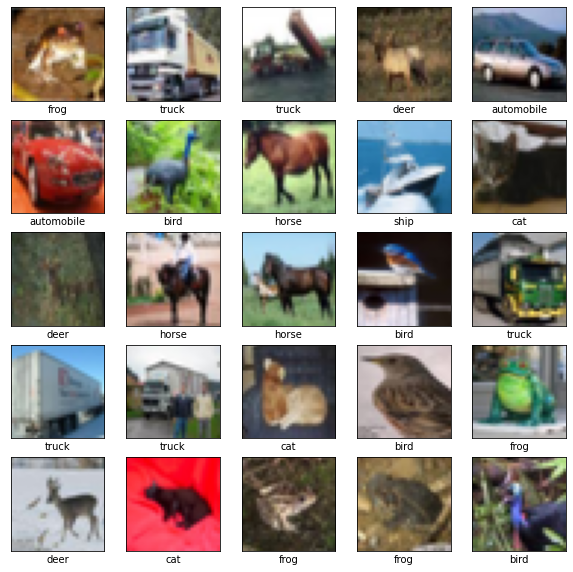

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Parfait, nous pouvons maintenant commencer les choses sérieuses !

# Classification supervisée

## Qu'est-ce que la classification supervisée ?

L'idée est de trouver une fonction de prédiction à partir des données annotées. Ici, cela revient à trouver la fonction qui à chaque image associe son label.

Cela est différent de l'apprentissage non-supervisée que l'on fera dans la suite.

## Comment allons-nous faire ?

Les images font 32 pixels par 32 avec 3 valeurs pour chaque couleur (**R**ouge, **V**ert, **B**leu ou **RVB** en français et **RGB** en anglais). Nous avons donc 32 * 32 * 3 = 3072 paramètres ...

Nous allons donc utiliser des réseaux de neurones pour approximer notre fonction de prédiction !

## Avec un réseau dense

### Rappel théorique

Si vous assistez aux premières formations, vous savez ce qu'est un réseau dense et si vous avez assisté au TP Multiperceptron, vous avez même codé votre propre réseau dense !

Pour ceux qui ne s'en souvienne plus, un réseau de neurone dense est composée de plusieurs couches, elles-mêmes composées de plusieurs noeuds. Chaque noeud est relié à tous les noeuds de la couche précédente, dont il pondère la somme des valeurs par des poids, et décale la valeur obtenue par un biais. Finalement, pour éviter que l'ensemble de toutes les couches se résument à une seule couche, on casse la linéarité en associant à chaque couche une fonction d'activation (sigmoïde, tanh, relu, etc.).

C'est une explication très très succinte. Pour mieux comprendre ce que c'est, vous pouvez revoir la formation sur les premières formations, ou il y a ces excellentes vidéos de [Science4All, Les réseaux de neurones | Intelligence artificielle 41](https://www.youtube.com/watch?v=8qL2lSQd9L8) (FR) et de [3Blue1Brown, But what is a Neural Network?](https://www.youtube.com/watch?v=aircAruvnKk) (ANG, mais très visuel).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/Neural_network.svg/220px-Neural_network.svg.png)

La première couche est appelée `Input layer`, car c'est là que sont insérées les données d'entrée. La dernière couche est appelée `Output layer` et correspond aux valeurs de sortie. Les couches intermédiaires sont appelées `Hidden layer`.

### En pratique

Pour créer un modèle avec **Keras**, on peut utiliser `keras.models.Sequential()`.

**Instruction :** Créer un modèle que vous assignerez à `model_dense1`.

In [5]:
model_dense1 = keras.models.Sequential()

Il est maintenant temps d'ajouter les premières couches à ce modèle. On pourra utiliser :
- `model_dense1.add(layer)` qui ajoute layer à la suite des couches du modèle.


- `keras.layers.Dense(n_noeuds, activation='...')` qui renvoie une couche dense avec `n_noeuds` noeuds et comme fonction d'activation celle que vous avez précisez (les options possibles sont notamment `sigmoid`, `tanh`, `relu`, `softmax`)

  Plus d'infos dans la doc de Keras : [Dense Layer](https://keras.io/api/layers/core_layers/dense/).


- `keras.layers.Flatten(input_shape=shape)` qui renvoie une couche qui *aplatit* les données d'entrée en une liste à la sortie.

  `input_shape` est un tuple qui permet de préciser le format des données d'entrée (Exemple (32, 32, 3) pour les images de CIFAR10).

Maintenant, réfléchissons un peu. Nos données d'entrée sont de la forme (32, 32, 3). Hors une couche dense ne peut prendre qu'une liste en entrée ... Il va donc falloir utiliser utiliser une première couche `Flatten` pour avoir le bon format.

**Instruction :** Rajoutez une couche `Flatten` au modèle.

*Note :* On pourrait également modifier les données d'entrée, mais vu que dans la suite, on va remanier les images, ça ne serait pas pratique.

In [6]:
model_dense1.add(keras.layers.Flatten(input_shape=(32, 32, 3)))

À la sortie de cette, nous avons donc une liste de 32 * 32 * 3 valeurs. On peut donc enfin mettre une première couche cachée !

**Instruction :** Rajoutez une couche `Dense` avec 512 noeuds et la fonction d'activation `relu`.

In [7]:
model_dense1.add(keras.layers.Dense(512, activation='relu'))

Ajoutons maintenant la couche de sortie, on a 10 classes possibles. Notre dernière couche aura donc 10 noeuds, et on aimerait que notre réseau prédise la probabilité de chaque classe, on utilisera donc la fonction d'activation `softmax`.

**Instruction :** Rajoutez une couche `Dense` avec 10 noeuds et la fonction d'activation `softmax`.

In [8]:
model_dense1.add(keras.layers.Dense(10, activation='softmax'))

In [9]:
model_dense1 = keras.models.Sequential()
model_dense1.add(layers.Dense(1024, activation='relu'))
model_dense1.add(layers.Dense(512, activation='relu'))
model_dense1.add(layers.Dense(256, activation='relu'))
model_dense1.add(layers.Dense(128, activation='relu'))
model_dense1.add(layers.Dense(10))

In [10]:
#model_dense1.summary()
model_dense1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model_dense1.fit(train_images, train_labels, epochs=2,
                    validation_data=(test_images, test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model_dense1.evaluate(test_images, test_labels, verbose=2)
print(test_acc)

Epoch 1/2


InvalidArgumentError: ignored

### Avec des CNNs

Bla bla

In [ ]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dense(10))

In [ ]:
model_cnn.summary()
model_cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model_cnn.fit(train_images, train_labels, epochs=5,
                    validation_data=(test_images, test_labels))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model_cnn.evaluate(test_images, test_labels, verbose=2)
print(test_acc)

## Auto-encodeurs et applications diverses

Je vais sûrement virer le réseau dense et garder que le CNN ici, vu que les CNNs auront été introduit ci-dessus.


## Auto-encodeur

Les auto-encodeurs sont une famille de réseaux de neurones particuliers qui ont pour premier objectif de réduire la dimension de l'espace des données qui nous intéressent. Il se décomposent en deux parties :

*   Un encodeur qui doit apprendre la représantation des données d'entrée qui permet de passer de la dimension initiale à la dimension réduite.
*   Un décodeur qui doit reproduire l'entrée le plus fidèlement possible à partir de la représentation que donne l'encodeur.

On retrouve donc un structure caractéristique en "goulot d'étranglement" où les couches aux extrémités sont de la même dimension que la taille des données à caractériser et où la couche centrale est de la dimension de reduction souhaitée qui contiendra la représentation des entrées.

![](https://www.researchgate.net/publication/318204554/figure/fig1/AS:512595149770752@1499223615487/Autoencoder-architecture.png)

Pour entrainer ce réseau, on va seulement utilisée les données d'entrées : pas besoin donc de labéliser les données, on laisse la descente de gradient faire tout le travail : il s'agit d'un apprentissage non-supervisé.

### Avec un réseau dense

Bla bla ...

In [ ]:
latent_dim = 512

class AutoencoderDense(Model):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(1024, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(1024, activation='relu'),
            layers.Dense(32 * 32 * 3, activation='sigmoid'),
            layers.Reshape((32, 32, 3))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### Avec des CNNs

Bla bla ...

In [ ]:
class AutoencoderCNN(Model):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            # layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            # layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
        ])

        self.decoder = tf.keras.Sequential([
            layers.Reshape((8, 8, 16)),
            # layers.UpSampling2D((2, 2)),
            # layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


Entrainement

In [ ]:
train = True 
autoencoder_cnn = None
if train:
    autoencoder_cnn = AutoencoderCNN(latent_dim)
    autoencoder_cnn.compile(optimizer='adam', loss=losses.MeanSquaredError())

    autoencoder_cnn.fit(train_images, train_images,
                    epochs=1,
                    shuffle=True,
                    validation_data=(test_images, test_images))

#    autoencoder_cnn.save('./models/model_cnn1')
#else:
#    autoencoder_cnn = models.load_model('./models/model_cnn1')
#    results = autoencoder_cnn.evaluate(test_images, test_images, verbose=2)
#    print('test loss : ', results)

Voir ce que l'auto-encodeur comprend.

In [ ]:
encoded_imgs = autoencoder_cnn.encoder(test_images).numpy()
decoded_imgs = autoencoder_cnn.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Applications diverses d'un auto-encodeur

# - Passer le truc en "mode TP" avec des instructions.
# - Problème dans le niveau des titres je crois


## Analyse des caractéristiques profondes de l'auto-encodeur et clustering

**Dans cette partie vous serez amenés à manipuler des méthodes et concepts que vous n'avez peut-être jamais vus et que nous n'avons pas encore expliqués dans les formations. Ce TP va vous permettre de les utiliser mais il n'y aura que très peu d'explications théoriques. On vous invite à lire les références que l'on vous donne pour comprendre le fonctionnement général des algorithmes. La plupart de ces méthodes vous seront présentées d'un point de vue plus théorique plus tard.**

###Vecteurs latents

Les vecteurs que l'on obtient après compression par l'auto-encodeur sont appelés **vecteurs latents**, ou **caractéristiques profondes**, ou **deep features**.
Ces termes ne sont pas réservés aux auto-encodeurs, il s'agit de n'importe quels vecteurs de dimension réduite provenant d'un réseau profond.

Ces vecteurs sont très utiles car ils sont de petites dimensions mais sont porteurs d'information sémantique. Autrement dit, ils "encodent" les données d'entrée du réseau, et sont un condensé des informations importantes.

> Prenons un exemple.
> Vous entrainez un réseau à reconnaitre des voitures (donc supervisé). Une fois que votre réseau est efficace sur des voitures, vous le coupez quelques couches avant la fin. Vous obtenez un réseau qui prend en entrée des images et donne en sortie un vecteur de petite dimension, disons 64. Comme votre réseau aura appris à extraire les informations utiles pour reconnaitre une voiture (roues, forme, etc), ces vecteurs comporteront toutes les informations nécessaires à reconnaitre des voitures.
Ensuite, si vous donnez à ce réseau des images de motos et de camions, une simple comparaison des vecteurs de sortie pourra indiquer si il s'agit d'une moto ou d'un camion. Il sera évidemment toujours peu efficace pour reconnaitre des objets éloignés des voitures, comme des visages par exemple. 

### But de cette dernière partie

Le but général de cette dernière partie est de vous montrer quelques outils classiques de machine learning et d'analyse des données. Dans la continuité de la première partie, l'idée est de pouvoir analyser les vecteurs latents provenants de l'auto-encoder. En particulier, vous serez capables d'appliquer un clustering non supervisé sur l'espace latent pour pouvoir retrouver les 10 classes de CIFAR-10, sans jamais utiliser les labels.

Pour cela on va voir chacun de ces outils de machine learning en s'entrainant sur la dataset "Wine" qui contient 3 classes de différents vins, dont chacun a 13 attributs (principalement les taux de présence de composés chimiques).

Nous verrons :
- l'importance de la normalisation des données
- la visualisation par t-SNE
- la réduction de dimensions par ACP
- le clustering par K-means
- le clustering par agglomération

Ensuite, vous pourrez appliquer un clustering aux données de l'auto-encodeur. Celui qui aura le meilleur score gagne le TP.

In [11]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.datasets import load_wine
data = load_wine()
train_data = data['data']
train_labels = data['target']

print(f"Les {train_data.shape[0]} vecteurs sont de dimension {train_data.shape[1]}.")

Les 178 vecteurs sont de dimension 13.


### Analyse des données

Il est souvent nécessaire de réduire la dimension des données que l'on manipule. Un encodeur (par exemple la première partie d'un auto-encodeur) est déjà un moyen de réduire les dimensions en codant des images dans un espace vectoriel beaucoup plus petit.
Un auto-encodeur a le rôle très particulier d'encoder des images (ou autres données structurées) mais d'autres algorithmes s'appliquent à des données vectorielles classiques.

La réduction de dimension permet à la fois à mieux visualiser les données (par exemple on peut réduire les vecteurs à 2 ou 3 dimensions pour afficher les données sur un graphique), et à la fois de pré-traiter les données. Pré-traiter les données en réduisant le nombre de dimensions est parfois indispensable, en effet, certains algorithmes - en particulier ceux basés sur la distances- supportent mal les très hautes dimensions.
> Pour ceux qui ca intéresse, voir "malédiction de la dimension". [version simple (wiki)](<https://fr.wikipedia.org/wiki/Fl%C3%A9au_de_la_dimension>) / [version hardcore](<https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.64.2646&rep=rep1&type=pdf>).

Dans la suite du TP, nous verrons la transformation t-SNE pour la visualisation, et l'ACP pour le pre-process.

**Il est important de noter que les données que l'on utilise pour le TP n'ont que 13 dimensions. C'est minuscule et ça ne nécessite pas de réduire encore plus la dimension, l'ACP est là à titre pédagogique. Par contre, pour la dernière question du TP, l'ACP sera très utile.**

#### Visualisation (t-SNE)

Le t-SNE (pour t-distributed stochastic neighbor embedding) est un algo de réduction de dimension spécialement conçu pour la visualisation de données. L'algorithme tend à maintenir les proximités entre les points depuis l'espace de grande dimension vers l'espace de petite dimension, selon une métrique donnée.

> Si vous voulez creuser son fonctionnement (ça demande quelques connaissances en théorie de l'information) : 
> [version simple](<https://aiaspirant.com/introduction-to-t-distributed-stochastic-neighbor-embeddingt-sne/>) / [version complète](<https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf>).

Notez que ca a été inventé par **Geoffrey Hinton**, un monument de l'IA, père de beaucoup d'autres méthodes. Vous allez probablement recroiser son nom souvent.

Comme on va le voir, le t-SNE n'est pas déterministe (c'est-à-dire qu'il a une part d'aléatoire dans son exécution), et c'est une chose à ne pas oublier quand vous l'utiliserez.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 18.134607
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.890663
[t-SNE] KL divergence after 300 iterations: 0.109683
Done in 0.5216615200042725s


Text(0.5, 1.0, 'Transformation t-SNE')

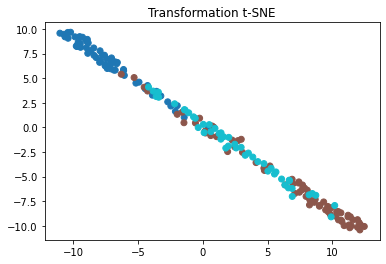

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
t0 = time()
tsne_results = tsne.fit_transform(train_data)
print(f"Done in {time() - t0}s")
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=train_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("Transformation t-SNE")

Le t-SNE n'est pas déterministe. Vous pouvez le vérifier en lançant plusieurs fois la réduction, vous n'aurez jamais le même résultat.

#### Normalisation des données

Beaucoup d'algorithmes se basent sur les distances entre les données. Or la qualité des calculs des distances dépend fortement de la normalisation des axes. Par exemple, un axe qui a des valeurs entre 0 et 100 aura une influence beaucoup plus forte car ses valeurs sont beaucoup plus grandes que celles prises dans un axe ayant des valeurs entre 0 et 1, et on verrait une distorsion artificielle le long de l'axe non normalisé.

Il y a principalement deux façons de normaliser, soit on ramène toutes les données entre un min et un max (MinMaxScaler), soit on normalise les données pour que chaque axe soit centré et réduit (StandardScaler).

In [13]:
for axe in range(train_data.shape[1]):
  extract = train_data[:, [axe]]
  print(f"axe {axe} - min {min(extract)} - max {max(extract)}")

axe 0 - min [11.03] - max [14.83]
axe 1 - min [0.74] - max [5.8]
axe 2 - min [1.36] - max [3.23]
axe 3 - min [10.6] - max [30.]
axe 4 - min [70.] - max [162.]
axe 5 - min [0.98] - max [3.88]
axe 6 - min [0.34] - max [5.08]
axe 7 - min [0.13] - max [0.66]
axe 8 - min [0.41] - max [3.58]
axe 9 - min [1.28] - max [13.]
axe 10 - min [0.48] - max [1.71]
axe 11 - min [1.27] - max [4.]
axe 12 - min [278.] - max [1680.]


Les différentes composantes des vecteurs d'entrainement n'ont pas du tout les mêmes plages de valeurs. Pour vous entrainer à manipuler les transformateurs de normalisation, affichez en dessous trois transformations t-SNE, une avec les données brutes, une avec une normalisation MinMax et une avec une normalisation gaussienne.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.012s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 18.134607
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.824875
[t-SNE] KL divergence after 300 iterations: 0.104126
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 1.839161
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.826118
[t-SNE] KL divergence after 300 iterations: 0.343846
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 178 samples in 0.000s...
[t-SNE] Computed neighbors for 178 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 178 / 178
[t-SNE] Mean sigma: 0.738166
[t-SNE] KL divergence after 250 iterat

Text(0.5, 1.0, 'données normées standard')

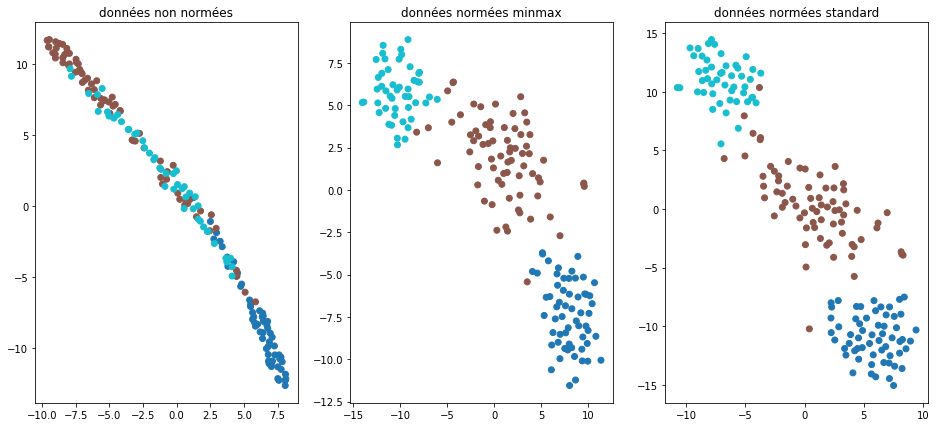

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler



tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_raw = tsne.fit_transform(train_data)

scaler = StandardScaler()
train_data_norm = scaler.fit_transform(train_data)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_norm = tsne.fit_transform(train_data_norm)

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_minmax = scaler.fit_transform(train_data)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_minmax = tsne.fit_transform(train_data_minmax)



colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 3, 1)
plt.scatter(tsne_results_raw[:,0], tsne_results_raw[:,1], c=train_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("données non normées")
ax2 = plt.subplot(1, 3, 2)
plt.scatter(tsne_results_norm[:,0], tsne_results_norm[:,1], c=train_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("données normées minmax")
ax3 = plt.subplot(1, 3, 3)
plt.scatter(tsne_results_minmax[:,0], tsne_results_minmax[:,1], c=train_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("données normées standard")

#### Réduction de dimension (ACP/PCA)

L'Analyse en Composante Principale est une autre méthode de réduction de dimension. L'ACP repose sur un principe intuitif : on recherche les directions dans lesquelles les données s'étalent le plus.

On vous encourage à regarder l'idée générale sur les liens ci-contre, ca se comprend très vite. 
[version simple (wiki)](<https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales>) / [version complète](<https://www.researchgate.net/publication/309165405_Principal_component_analysis_-_a_tutorial>).

C'est la technique qui est de très loin la plus utilisée pour la réduction de dimension. Elle permet notamment de savoir combien d'information on perd lorsque l'on réduit la dimension. Elle a beaucoup d'autres avantages qui seront détaillés dans la suite.

Done in 0.0014195442199707031s

Explained variation per principal component: 
 [0.36198848 0.1920749  0.11123631 0.0706903  0.06563294 0.04935823
 0.04238679 0.02680749 0.02222153 0.01930019] 



Text(0.5, 1.0, 'Variance expliquée cumulée')

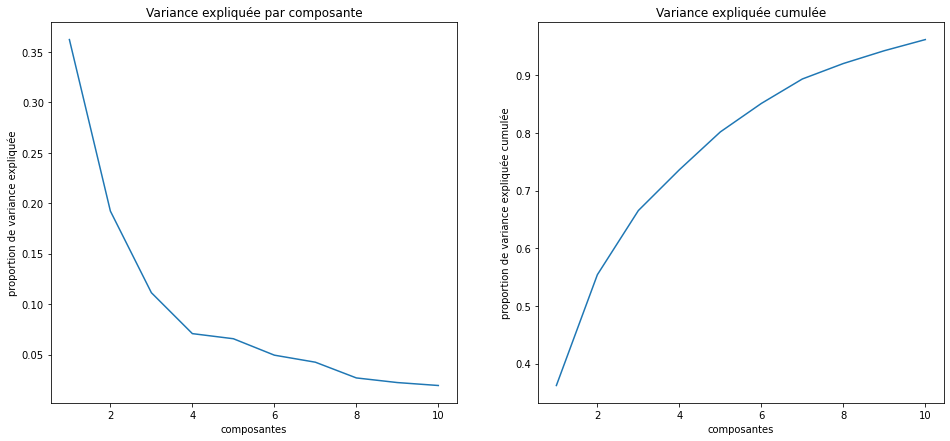

In [16]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components=n_components, svd_solver='full', whiten=True)

t0 = time()
pca_results = pca.fit_transform(train_data_norm)
print(f"Done in {time() - t0}s")

components = range(1, n_components+1)
explained_variance = pca.explained_variance_ratio_
plt.show()
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
plt.plot(components, explained_variance)
plt.xlabel("composantes")
plt.ylabel("proportion de variance expliquée")
plt.title("Variance expliquée par composante")
ax2 = plt.subplot(1, 2, 2)
plt.plot(components, np.cumsum(explained_variance))
print('\nExplained variation per principal component: \n {} \n'.format(pca.explained_variance_ratio_))
plt.xlabel("composantes")
plt.ylabel("proportion de variance expliquée cumulée")
plt.title("Variance expliquée cumulée")

Le graphe précédent montre la proportion de variance expliquée sur chacune des composantes principales. Intuitivement, il s'agit de la proportion d'information contenue dans chacune des composantes.
Suivant vos besoins, vous pouvez donc garder les composantes principales qui vous sont utiles.
En ce qui concerne les données que l'on manipule ici, on remarque que 6 dimensions sont nécessaires pour expliquer plus de 90% de la variance.

Done in 0.0014727115631103516s


Text(0.5, 1.0, "Les deux premières composantes de l'ACP")

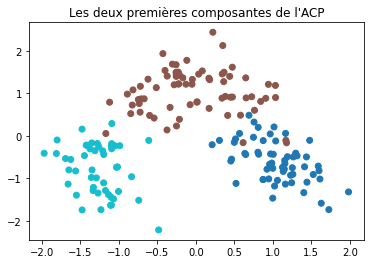

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='full', whiten=True)

t0 = time()
pca_results = pca.fit_transform(train_data_norm)
print(f"Done in {time() - t0}s")

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.scatter(pca_results[:,0], pca_results[:,1], c=train_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("Les deux premières composantes de l'ACP")

#### Pourquoi une ACP, pourquoi un t-SNE ?

On l'a vu, le t-SNE a l'air d'être efficace pour réduire les dimensions, alors pourquoi on utilise une ACP pour le traitement réel des données ? 

C'est parce-que la transformation t-SNE souffre de quelques points noirs :

- Le t-SNE, comme on l'a vu, n'est pas déterministe. La sortie change à chaque exécution, ce qui peut poser problème pour la manipulation des données après la transformation. L'ACP par contre fournit des résultats déterministes.

- Le t-SNE se base sur les relations entre les points voisins mais ne permet pas toujours de visualiser les tendances globales. Vous aurez toujours des données bien étalées dans l'espace alors que les données d'entrée ne le sont pas forcément. C'est aussi ce qui rend le t-SNE parfois très utile pour visualiser les données.

- Les composantes principales en sortie d'ACP portent en elles-mêmes une signification puisqu'elles se décomposent selon des composantes d'entrée. Si les données d'entrée ont un sens, alors les sorties auront un sens.
> Par exemple, si on veut prédire le prix d'une maison, une ACP nous donne des informations du type : "La composante principale qui explique le prix d'une maison est composée à 20% de sa localisation, à 30% de sa surface, ...".

- L'ACP permet d'obtenir les matrices de passage d'un espace à l'autre qui peuvent être utilisées pour projeter facilement de nouvelles données dans l'espace réduit.

- L'ACP sert de base a beaucoup d'autres algorithmes, qui sont utiles pour des cas particuliers ou des cas extremes (peu de données, données mal réparties, etc).

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.003s...
[t-SNE] Computed neighbors for 569 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 0.430144
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.667854
[t-SNE] KL divergence after 300 iterations: 0.921332


Text(0.5, 1.0, 'Transformation par ACP')

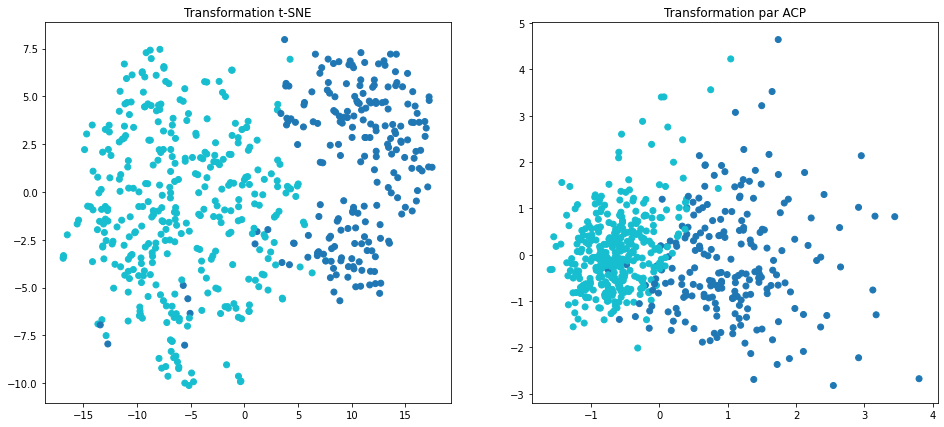

In [18]:
from sklearn.datasets import load_breast_cancer
data_cancer = load_breast_cancer()
train_data_cancer = data_cancer['data']
train_labels_cancer = data_cancer['target']

scaler_cancer = StandardScaler()
train_data_cancer = scaler.fit_transform(train_data_cancer)

pca_cancer = PCA(n_components=2, svd_solver='full', whiten=True)
pca_results_cancer = pca.fit_transform(train_data_cancer)

tsne_cancer = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_cancer = tsne.fit_transform(train_data_cancer)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
plt.title("Transformation t-SNE")
plt.scatter(tsne_results_cancer[:,0], tsne_results_cancer[:,1], c=train_labels_cancer, cmap=matplotlib.colors.ListedColormap(colors))
ax2 = plt.subplot(1, 2, 2)
plt.scatter(pca_results_cancer[:,0], pca_results_cancer[:,1], c=train_labels_cancer, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("Transformation par ACP")

En comparant les deux algorithmes, on remarque l'étalement provoqué par le t-SNE. C'est utile pour bien visualiser les données mais on perd l'information qui concerne les tendances globales des données. L'ACP donne des nuages de points plus denses ce qui les rend moins simple à visualiser, mais la tendance globale du nuage de point est bien visible.

#### Quelques autres algos

D'autres algorithmes permettent la réduction de dimension dans des cas particuliers :

- La PLS (ou régression des moindres carrés partiels) est équivalente à l'ACP mais elle est supervisée. Ça permet de chercher les composantes principales qui permettent le mieux de distinguer les classes (qui sont donc connues).

- L'algorithme FCA analyse les relations entre deux variable qualitatives. C'est donc une ACP pour des données d'entrée non numériques, et pour lesquelles on ne peut pas facilement définir de distance.

### Classification non supervisée (clustering)

#### K-means

Le K-means est un algorithme de clustering. Il fonctionne donc de manière non supervisé et se base sur une distance pour comparer les vecteurs.

> Le K-means est un algo itératif. À l'initialisation, il prend k points répartis aléatoirement (que nous appelerons les *centroïdes*). Chaque itération comporte deux étapes :
- On attribue chaque point des données à un des *centroïdes*. Dans sa forme basique, chaque donnée est attribuée au *centroïde* qui est le plus proche.
- Pour chaque *centroïde*, on regroupe tous les points qui lui sont attribués, ceux-ci forment un cluster ; puis chaque *centroïde* est mis à jour comme étant le barycentre de son nouveau cluster.

>  Ces étapes sont répétées jusqu'à l'arrêt par un critère de convergence.

<img src="https://stanford.edu/~cpiech/cs221/img/kmeansViz.png" width="440" height="260" align="center"/>

Pour avoir plus d'infos sur le K-means : [Anas Al-Masri : How does K-means work ?](<https://towardsdatascience.com/how-does-k-means-clustering-in-machine-learning-work-fdaaaf5acfa0>)


Il a l'avantage d'être simple et rapide, mais nécessite de donner le nombre de clusters k, et c'est une information que l'on n'a pas toujours. De plus, le choix des valeurs initiales des *centroïdes* influent beaucoup sur le résultat.

La solution classique pour pallier ce problème consiste à initialiser les *centroïdes* aléatoirement et lancer l'algorithme plusieurs fois, et avec différentes valeurs de k. Il existe aussi une variante kmeans++ qui intialise les *centroïdes* de manière à optimiser le résultat.



Text(0.5, 1.0, 'Predictions du K-means')

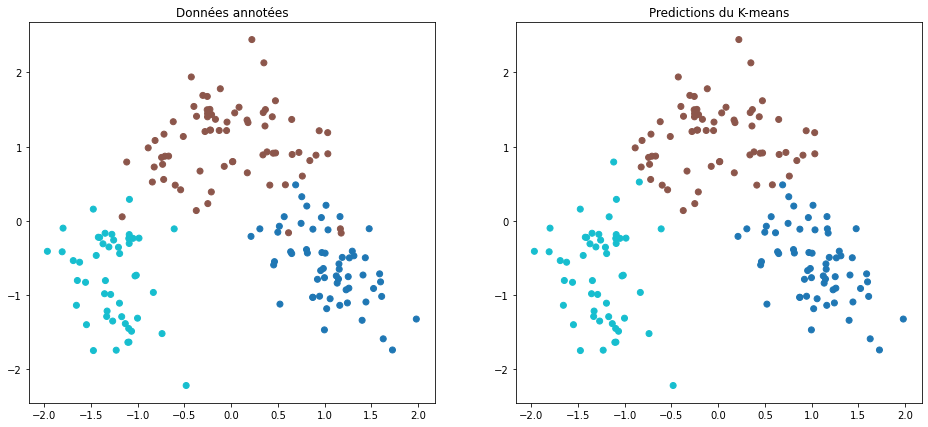

In [19]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
prediction = kmeans.fit_predict(train_data_norm)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(pca_results[:,0], pca_results[:,1], c=train_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("Données annotées")
ax2 = plt.subplot(1, 2, 2)
plt.scatter(pca_results[:,0], pca_results[:,1], c=prediction, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("Predictions du K-means")

#### Clustering agglomératif

Le clustering agglomeratif consiste à constuire un arbre de similitude entre les données.
Dans sa forme la plus simple, il s'agit de réunir itérativement les données les plus proches.

> En deux mots. On initialise en considèrant chacun des points comme un cluster ayant un unique point. Ensuite à chaque étape on calcule les barycentres de chacun des clusters, et on regroupe les clusters dont les barycentres sont les plus proches.

<img src="https://cedric.cnam.fr/vertigo/Cours/RCP216/_images/hierarchicalClustering.png" width="440" height="160" align="center"/>

Pour en savoir plus : 
[version simple (wiki)](<https://fr.wikipedia.org/wiki/Regroupement_hi%C3%A9rarchique>) / [version complète](<lien>)

Le grand avantage de cette technique c'est qu'elle ne nécessite pas de connaitre k en avance. On peut lancer l'algorithme et couper l'arbre au nombre de cluster qui nous convient ou qui donne le meilleurs score.

Il existe différentes facon de regrouper les clusters, et différentes variantes. Par exemple, on peut aussi considérer tous nos points comme un seul grand cluster, puis le diviser itérativement de manière optimale. 

Text(0.5, 1.0, "Predictions de l'AC")

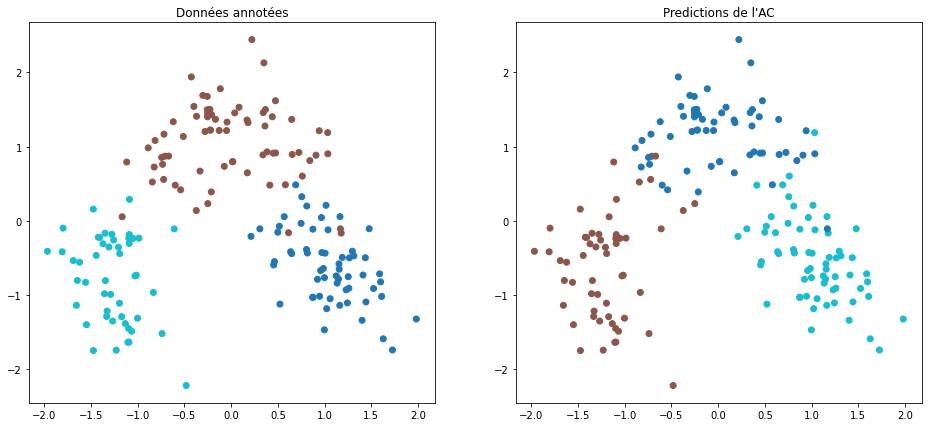

In [20]:
from sklearn.cluster import AgglomerativeClustering

AC = AgglomerativeClustering()
AC.set_params(n_clusters=3)
prediction = AC.fit_predict(train_data_norm)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
plt.scatter(pca_results[:,0], pca_results[:,1], c=train_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("Données annotées")
ax2 = plt.subplot(1, 2, 2)
plt.scatter(pca_results[:,0], pca_results[:,1], c=prediction, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("Predictions de l'AC")

La bbilothèque Scikit ne permet pas de visualiser le clustering hiérarchique. Ci-dessous on utilise Scipy pour afficher le dendogramme. On voit qu'il est assez facile de couper l'arbre à la bonne hauteur pour choisir le nombre de clusters.

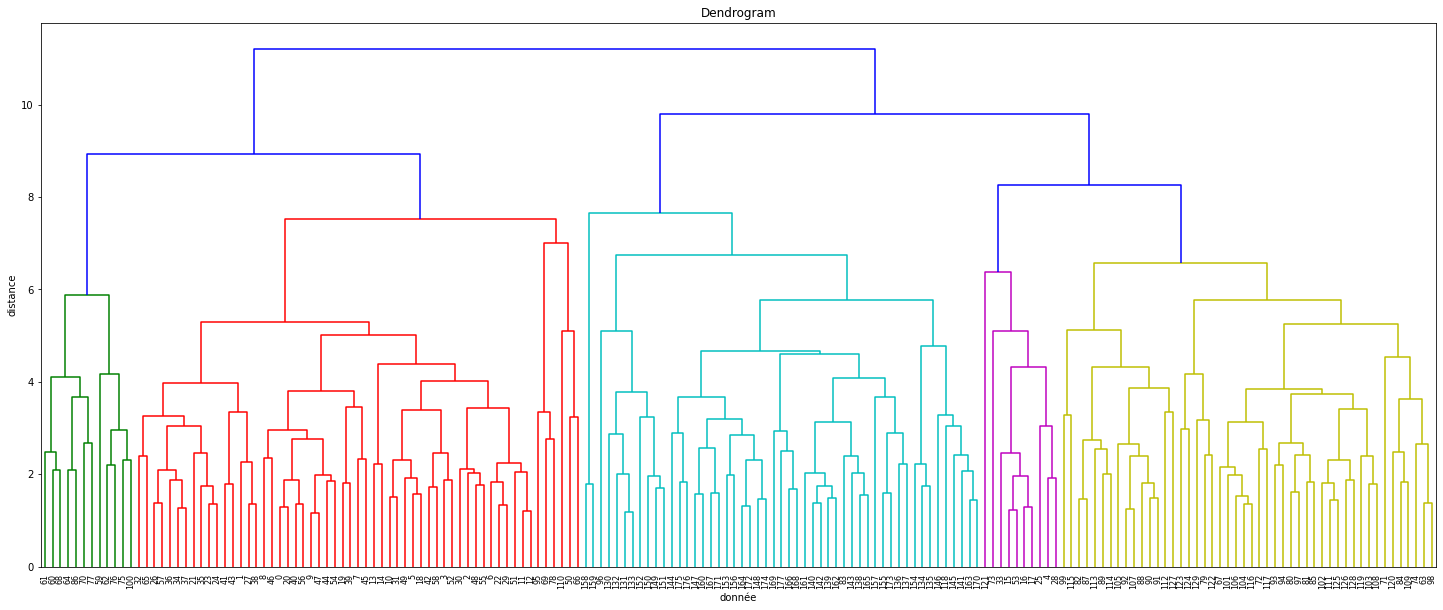

In [21]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

hc_complete = linkage(train_data_norm, "complete")

plt.figure(figsize=(25, 10))
plt.title('Dendrogram')
plt.xlabel('donnée')
plt.ylabel('distance')
dendrogram(
    hc_complete,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

#### Score NMI

Trouver une bonne métrique pour mesurer la qualité d'un clustering non supervisé n'est pas si simple. En effet, la plupart des métriques classiques se contentent de comparer les *labels* prédits aux vrais labels. Mais dans notre cas, nous avons deux problèmes :

  - En non-supervisé sur des données brutes, on n'a pas forcément ces *labels* vrais. Il faut donc se contenter de mesurer à quel point les classes sont denses (**inertie intra-cluster**), et à quel point les différentes classes sont éloignées (**inertie inter-cluster**). Il existe beaucoup de métriques de ce type, on peut citer le **coefficient de Silhouette** ou encore **l'indice de Calinski-Harabasz.**

- Lorsque l'on a les labels vrais, ce n'est pas gagné non plus. En effet, si l'algorithme prédit [1, 1, 2, 2, 3, 3] alors que les vraies valeurs sont [3, 3, 1, 1, 2, 2], l'algorithme n'a pas fait d'erreur de clustering, mais une comparaison label à label donnerait un score nul. Il faut donc une métrique qui ne soit pas basée sur le nom des classes. On peut utiliser **l'Adjusted Rand Index (ARI)** ou encore **l'indice de Jacard**, mais pour le TP je vous propose le score **NMI (Normalized Mutual Information)**.



> Pour plus d'informations sur les mesures de qualité du clustering, voir 
[Manimaran : Clustering Evaluation strategies](<https://towardsdatascience.com/clustering-evaluation-strategies-98a4006fcfc>)

Score NMI : 0.8758935341223069
k = 9

Text(0.5, 1.0, 'Qualité du clustering en fonction du nombre de clusters')

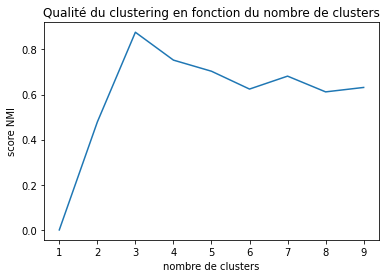

In [22]:
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI


kmeans = KMeans(n_clusters=3, random_state=0)
prediction = kmeans.fit_predict(train_data_norm)

print("Score NMI :", NMI(prediction, train_labels))

#À vous de jouer ! Tracez le score en MNI en fonction du nombre de cluster (de 5 à 20) :

cluster = []
scores = []

for k in range(1, 10):
  kmeans = KMeans(n_clusters=k, random_state=0)
  prediction = kmeans.fit_predict(train_data_norm)
  cluster.append(k)
  score = NMI(prediction, train_labels)
  scores.append(score)
  print(f"\rk = {k}", end='')

plt.plot(cluster, scores)
plt.xlabel("nombre de clusters")
plt.ylabel("score NMI")
plt.title("Qualité du clustering en fonction du nombre de clusters")

On voit que le meilleur clustering se fait pour k=3. Il n'y a rien de très étonnant puisque nous avions trois classes dans les données. Lorsque vous manipulez des données sans connaitre k, cette méthode est un bon moyen de savoir quel est le nombre optimal de classes.

### Pipeline sci-kit
(cette sous-partie présente juste une astuce de programmation, peu connue, et très utile)

La manière la plus propre d'utiliser sci-kit lorsque l'on a besoin d'un enchainement de plusieurs transformations, c'est d'utiliser les **pipelines**.

Il s'agit d'un regroupement de plusieurs objets *transformers* réunis dans un seul objet ```Pipeline()```.

```
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('nom_1', objet_transformateur_1()),
    ('nom_2', objet_transformateur_2()),
    etc...
])
```

Pour manipuler votre Pipeline, vous pouvez utiliser les même méthodes que pour les transformateurs : ```.fit()```, ```.predict()```, ```.fit_predict()```, etc.

> Vous pouvez aussi réécrire (en subclassing) les classes ```BaseEstimator```, ```TransformerMixin``` pour faire vos propres transformateurs et les inclure dans des pipelines.

Pour vous entrainer, essayez de  créer et entrainer une pipeline qui regroupe une ACP et un Kmeans sur les données ```train_data_viz```.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#ceci est un exemple de pipeline, mais en fait il est inutile de faire une ACP ici
pipeline = Pipeline([
    ('pca', PCA(n_components=10, svd_solver='full', whiten=True)),
    ('kmeans', KMeans(n_clusters=3, random_state=0)),
])


pipeline.fit(train_data_norm)
prediction = pipeline.predict(train_data_norm)

print("Score NMI :", NMI(prediction, train_labels))

Score NMI : 0.8985432342138455


# À vous de jouer en utilisant tout ça !

Pour finir le TP, essayez de faire une classification non-supervisée sur CIFAR-10. Celui qui a le score NMI le plus haut gagne le TP.

> Indice :
> Vous pouvez extraire des caractéristiques grace à un auto-encodeur, puis les classifier avec un algorithme de clustering de votre choix.

N'oubliez pas que vous ne devrez pas utiliser les *labels*, sauf pour le calcul du score NMI.

---
PS : Si vous êtes motivés, vous pouvez coder un k-means *from scratch* (avec numpy), c'est pas hyper long et ca permet de bien comprendre l'algo.